# Introdução

Neste documento realizamos os embeddings de cada trecho formatado anteriormente, incluindo o titulo e o resumo.

Esses embeddings serão salvos em uma vectorstore.

# Parte 0: Instalações

In [1]:
# %pip install faiss-gpu

# Parte 1: Listagem dos Documentos

In [2]:
import os
import json

In [3]:
pdf_folder_path = "./formatted_documents"

In [4]:
filename_list = []
for filename in os.listdir(pdf_folder_path):
    if filename.endswith(".json"):
        filename_list.append(os.path.join(pdf_folder_path, filename))

filename_list = sorted(filename_list)

In [5]:
len(filename_list)

1538

In [6]:
def retrieve_document(filename):
    with open(filename, "r") as file:
        json_file = json.load(file)
    return json_file

## Teste

In [7]:
json_document = retrieve_document(filename_list[0])

print(json_document["abstract"])

Esta pesquisa analisa a organização do trabalho de psicólogos nas equipes do Núcleo de Apoio à Saúde da Família (NASF) do município do Rio de Janeiro (área programática 2.1). Para tanto, apresenta o contexto de trabalho atual dos psicólogos no âmbito da atenção básica, identifica o trabalho prescrito e o realizado; as vivências de sofrimento dos psicólogos em seu contexto de trabalho; assim como as vivências de prazer e estratégias utilizadas para a efetivação da prática profissional. A metodologia caracteriza-se pela realização de entrevistas semiestruturadas com seis psicólogas e um psicólogo, todos de equipes NASF (eNASF) da área da Zona Sul do município. As entrevistas ocorreram entre fevereiro de 2019 e fevereiro de 2020, foram gravadas e transcritas, e posteriormente analisadas por meio da Análise dos Núcleos de Sentido. O contexto de trabalho presente no município do Rio caracteriza-se por: redução gradual de investimentos na Saúde; transferência parcial de gestão dos serviços g

In [8]:
print(len(json_document["sentences"]))

411


# Parte 2: Criação de Documents

In [9]:
from langchain.docstore.document import Document
from lib.document import DocumentConstructor

In [10]:
# MAX WINDOW SIZE (quantidade de paragrafos sequencias unidos)
# MAX TOKEN SIZE (quantidade de tokens em um embedding)
# MIN TOKEN SIZE (quantidade minima de tokens em um embedding)
document_constructor = DocumentConstructor(5, 500, 100)

## Teste

In [11]:
documents = document_constructor.create_documents(json_document)

In [12]:
len(documents)

1342

In [13]:
documents[0]

Document(page_content='Psicologia, trabalho e atenção básica do SUS : compartilhando experiências em equipes NASF no Rio de Janeiro', metadata={'id': '276189', 'type': 'title'})

In [14]:
documents[1]

Document(page_content='Esta pesquisa analisa a organização do trabalho de psicólogos nas equipes do Núcleo de Apoio à Saúde da Família (NASF) do município do Rio de Janeiro (área programática 2.1). Para tanto, apresenta o contexto de trabalho atual dos psicólogos no âmbito da atenção básica, identifica o trabalho prescrito e o realizado; as vivências de sofrimento dos psicólogos em seu contexto de trabalho; assim como as vivências de prazer e estratégias utilizadas para a efetivação da prática profissional. A metodologia caracteriza-se pela realização de entrevistas semiestruturadas com seis psicólogas e um psicólogo, todos de equipes NASF (eNASF) da área da Zona Sul do município. As entrevistas ocorreram entre fevereiro de 2019 e fevereiro de 2020, foram gravadas e transcritas, e posteriormente analisadas por meio da Análise dos Núcleos de Sentido. O contexto de trabalho presente no município do Rio caracteriza-se por: redução gradual de investimentos na Saúde; transferência parcial d

In [16]:
# documents[2]

<Axes: ylabel='Frequency'>

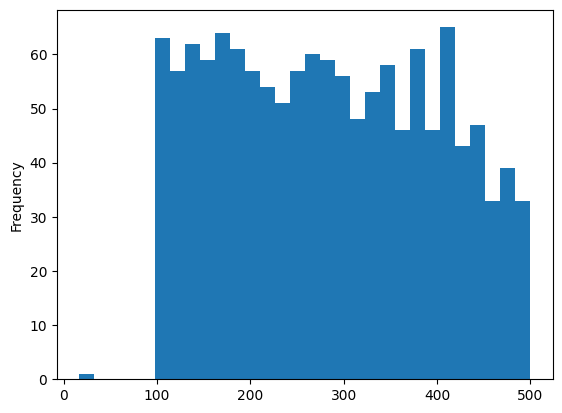

In [17]:
import pandas as pd
pd.Series([len(doc.page_content.split()) for doc in documents]).plot.hist(bins=30)

# Parte 3: Recuperação de todos os documentos

In [18]:
# documents = []

# for filename in filename_list:
#     json_doc = retrieve_document(filename)
#     docs = document_constructor.create_documents(json_doc)
#     documents.extend(docs)

In [19]:
# len(documents)

# Parte 4: Vector Store

In [20]:
from operator import itemgetter

from langchain.prompts import ChatPromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.vectorstores import FAISS

In [21]:
from langchain.embeddings import HuggingFaceEmbeddings, SentenceTransformerEmbeddings, HuggingFaceBgeEmbeddings

In [22]:
embeddings = SentenceTransformerEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

/home/vinic/miniconda3/envs/llama/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Parte 5: Obter todos os embeddings e Salvar Vector Store

In [23]:
# json_doc = retrieve_document(filename_list[0])
# docs = document_constructor.create_documents(json_doc)
    
# vectorstore = FAISS.from_documents(docs, embedding=embeddings)

In [24]:
# for filename in filename_list[1:]:
#     json_doc = retrieve_document(filename)
#     docs = document_constructor.create_documents(json_doc)
    
#     new_vectorstore = FAISS.from_documents(docs, embedding=embeddings)
#     vectorstore.merge_from(new_vectorstore)
    
#     print('.', end='')

In [25]:
# vectorstore.save_local("./faiss_vector_store/")

In [26]:
total_files = len(filename_list)
total_files

1538

In [ ]:
for start in range(0, total_files, 300):
    end = start + 300
    
    print("Starting", start, "...", end)
    docs = []
    for filename in filename_list[start:end]:
        json_doc = retrieve_document(filename)
        doc = document_constructor.create_documents(json_doc)
        docs.extend(doc)
        print('.', end='')
    
    new_vectorstore = FAISS.from_documents(docs, embedding=embeddings)
    os.mkdir(f"./partial_faiss_vector_store_{start}/")
    new_vectorstore.save_local(f"./partial_faiss_vector_store_{start}/")
    del(new_vectorstore)
    sleep(1)

Starting 0 ... 300
............................................................................................................................................................................................................................................................................................................

# Parte 6: Merge das vector stores

In [4]:
import os
import json
from time import sleep

In [5]:
vector_stores_paths = []
for filename in os.listdir('.'):
    if filename.startswith("partial_faiss"):
        vector_stores_paths.append(os.path.join('.', filename))

vector_stores_paths = sorted(vector_stores_paths)

In [6]:
len(vector_stores_paths)

31

In [7]:
vector_stores_paths[:5]

['./partial_faiss_vector_store_0',
 './partial_faiss_vector_store_100',
 './partial_faiss_vector_store_1000',
 './partial_faiss_vector_store_1050',
 './partial_faiss_vector_store_1100']

In [8]:
vectorstore = FAISS.load_local(vector_stores_paths[0], embeddings=embeddings)
print(vector_stores_paths[0])

for vector_store_path in vector_stores_paths[1:20]:
    new_vectorstore = FAISS.load_local(vector_store_path, embeddings=embeddings)
    vectorstore.merge_from(new_vectorstore)
    print(vector_store_path)
    del(new_vectorstore)
    sleep(1)

vectorstore.save_local(f"./partial_faiss_vector_store_part_1/")

./partial_faiss_vector_store_0
./partial_faiss_vector_store_100
./partial_faiss_vector_store_1000
./partial_faiss_vector_store_1050
./partial_faiss_vector_store_1100
./partial_faiss_vector_store_1150
./partial_faiss_vector_store_1200
./partial_faiss_vector_store_1250
./partial_faiss_vector_store_1300
./partial_faiss_vector_store_1350
./partial_faiss_vector_store_1400
./partial_faiss_vector_store_1450
./partial_faiss_vector_store_150
./partial_faiss_vector_store_1500
./partial_faiss_vector_store_200
./partial_faiss_vector_store_250
./partial_faiss_vector_store_300
./partial_faiss_vector_store_350
./partial_faiss_vector_store_400
./partial_faiss_vector_store_450


In [9]:
vectorstore = FAISS.load_local(vector_stores_paths[20], embeddings=embeddings)
print(vector_stores_paths[20])

for vector_store_path in vector_stores_paths[21:]:
    new_vectorstore = FAISS.load_local(vector_store_path, embeddings=embeddings)
    vectorstore.merge_from(new_vectorstore)
    print(vector_store_path)
    del(new_vectorstore)
    sleep(1)

vectorstore.save_local(f"./partial_faiss_vector_store_part_2/")

./partial_faiss_vector_store_50
./partial_faiss_vector_store_500
./partial_faiss_vector_store_550
./partial_faiss_vector_store_600
./partial_faiss_vector_store_650
./partial_faiss_vector_store_700
./partial_faiss_vector_store_750
./partial_faiss_vector_store_800
./partial_faiss_vector_store_850
./partial_faiss_vector_store_900
./partial_faiss_vector_store_950


In [ ]:
part1 = FAISS.load_local(f"./partial_faiss_vector_store_part_1/", embeddings=embeddings)
part2 = FAISS.load_local(f"./partial_faiss_vector_store_part_2/", embeddings=embeddings)
part1.merge_from(part2).save_local(f"./faiss_vector_store/")

# Extra

## Proximidade de Resumos

In [ ]:
res = vectorstore.similarity_search_with_score(
    "Um dos métodos mais robustos para caracterizar tamanho, forma, densidade, atmosfera, anéis, etc, é a ocultação estelar. Este trabalho apresenta a análise de duas ocultações por Cere,o trabalho de ocultações por TNOs",
    k=10,
    fetch_k=100000,
    filter=dict(type="abstract")
)
len(res)

In [ ]:
res

## Proximidade de Frases

In [ ]:
res = vectorstore.similarity_search_with_score(
    "quero um resumo sobre o cenario atual em estudos sobre alavancagem financeira",
    k=100,
    fetch_k=100000,
    filter=dict(type="sentences")
)
len(res)

In [ ]:
for r in res[:10]:
    print(r[0].page_content, "\n")

In [ ]:
results = {}

for doc in res:
    _id = doc[0].metadata["id"]
    _start_index = doc[0].metadata["start_index"]
    
    if _id not in results.keys():
        results[_id] = {}

    if _start_index not in results[_id].keys():
        results[_id][_start_index] = []
    
    results[_id][_start_index].append(doc)

In [ ]:
results.keys()

In [ ]:
# results['11422-4587']

In [ ]:
results['11422-10324'].keys()

# RAG

In [ ]:
openai_api_key = "xxxxxx"

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain.schema import HumanMessage, SystemMessage

In [ ]:
chat = ChatOpenAI(
    model_name='gpt-3.5-turbo-16k',
    temperature = 0.0,
    openai_api_key = openai_api_key,         
    max_tokens=6000
)

In [ ]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 10})

In [ ]:
retrieved_docs = retriever.get_relevant_documents(
    "quero um resumo sobre o cenario atual em estudos sobre alavancagem financeira dentro do escopo de estudo dos corpos solares"
)

In [ ]:
from langchain.prompts import PromptTemplate

template = """
Use as seguintes partes do contexto para responder à pergunta no final.
Essas partes são retiradas de artigos científicos.
Se você não sabe a resposta, apenas diga que não sabe, não tente inventar uma resposta.

{context}

Pergunta: {question}
Resposta útil:
"""

def format_docs(docs):
    # print("'''" + "'''\n\n'''".join(doc.page_content for doc in docs) + "'''")
    return "\n\n".join(doc.page_content for doc in docs)

rag_prompt_custom = PromptTemplate.from_template(template)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt_custom
    | chat
    | StrOutputParser()
)

In [ ]:
rag_chain.invoke("comente sobre as pesquisas em Realidade Virtual e Aumentada sob a perspectiva da indústria 4.0?")